
# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### we start off by taking a better look at our data sets

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.isna().sum()/profile.shape[0]

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


### Cleaning Data
#### Now that we have looked at our data, we take a deeper and start cleaning the data

In [8]:
#let's start with the portfolio data set. 
#one-hot encording for channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0


In [9]:
for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if channel in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0

In [10]:
#rename person to customer_id
portfolio = portfolio.rename(columns = {'id' : 'offer_id'})

portfolio.shape

(10, 13)

In [11]:
#check for null values
portfolio.isnull().sum()

channels         0
difficulty       0
duration         0
offer_id         0
offer_type       0
reward           0
web              0
email            0
social           0
mobile           0
bogo             0
informational    0
discount         0
dtype: int64

In [12]:
# working with the profile data
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [14]:
#taking another look at the profile dataset, we realize that the age 118 has Nans on the gender and the income, therefore we 
#choose to drop it

profile = profile[profile.age != 118]
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [15]:
#change the datatype(became_member_on) into string
profile['became_member_on'] = profile['became_member_on'].astype(str)

#make a column for the year
profile['membership_year'] = profile['became_member_on'].apply(lambda x: x[0:4])

#change into datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

#rename id to customer_id
profile = profile.rename(columns = {'id' : 'customer_id'})


In [16]:
profile.head()

,age,became_member_on,gender,customer_id,income,membership_year
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [17]:
# working with the transcript data

transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript[transcript["person"]=='78afa995795e4d85b5d9ceeca43f5fef'].value.values

array([{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},
       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}, {'amount': 19.89},
       {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
       {'amount': 17.78}, {'offer id': '5a8bc65990b245e5a138643cd4eb9837'},
       {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}, {'amount': 19.67},
       {'amount': 29.72}, {'amount': 23.93},
       {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},
       {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},
       {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}, {'amount': 21.72},
       {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
       {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5},
       {'amount': 26.56}, {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}], dtype=object)

In [19]:
# Extract each key that exist in 'value' column to a seperate column.
# getting the different keys  that exists in the 'value' column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [20]:
keys

['offer id', 'amount', 'offer_id', 'reward']

In [21]:
transcript['offer_id'] = '' 
transcript['amount'] = 0  
transcript['reward'] = 0  

In [22]:
# Iterating over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': 
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [23]:
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)
transcript.drop('value', axis=1, inplace=True)

In [24]:
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [25]:
dummy = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, dummy], axis = 1)

#rename person to customer_id
transcript = transcript.rename(columns = {'person' : 'customer_id'})

#drop amount column
transcript = transcript.drop(columns = 'amount')
transcript = transcript.drop(columns = 'reward')

In [26]:
transcript.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [27]:
#checking for null values
transcript.isnull().sum()

event              0
customer_id        0
time               0
offer_id           0
offer completed    0
offer received     0
offer viewed       0
transaction        0
dtype: int64

### Data Exploration and Data Visualization

Merging all the data sets together

In [28]:
df = pd.merge(transcript, profile, on= 'customer_id')

In [29]:
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,membership_year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,F,100000.0,2017
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,F,100000.0,2017
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,N/A,0,0,0,1,75,2017-05-09,F,100000.0,2017
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,F,100000.0,2017
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,N/A,0,0,0,1,75,2017-05-09,F,100000.0,2017


In [30]:
df = pd.merge(df, portfolio, on = 'offer_id', how = 'left')


In [31]:
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,...,duration,offer_type,reward,web,email,social,mobile,bogo,informational,discount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,N/A,0,0,0,1,75,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,N/A,0,0,0,1,75,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.describe()

,time,offer completed,offer received,offer viewed,transaction,age,income,difficulty,duration,reward,web,email,social,mobile,bogo,informational,discount
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.0,148805.0,148805.0
mean,366.707694,0.118946,0.243806,0.182797,0.454451,53.840696,64337.000755,7.890561,6.625207,4.442445,0.806747,1.0,0.658311,0.917160,0.0,0.0,0.0
std,200.359087,0.323726,0.429378,0.386500,0.497922,17.551337,21243.762941,5.041335,2.133035,3.372362,0.394851,0.0,0.474277,0.275641,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0
25%,186.000000,0.000000,0.000000,0.000000,0.000000,41.000000,48000.000000,5.000000,5.000000,2.000000,1.000000,1.0,0.000000,1.000000,0.0,0.0,0.0
50%,408.000000,0.000000,0.000000,0.000000,0.000000,55.000000,62000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
75%,528.000000,0.000000,0.000000,0.000000,1.000000,66.000000,78000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
max,714.000000,1.000000,1.000000,1.000000,1.000000,101.000000,120000.000000,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0


In [33]:
df = df.dropna()

In [34]:
# ensuring we have clean data
df.isnull().sum().sum()

0

In [35]:
df.describe()

,time,offer completed,offer received,offer viewed,transaction,age,income,difficulty,duration,reward,web,email,social,mobile,bogo,informational,discount
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.0,148805.0,148805.0
mean,354.570223,0.218030,0.446900,0.335069,0.0,54.779282,66414.119149,7.890561,6.625207,4.442445,0.806747,1.0,0.658311,0.917160,0.0,0.0,0.0
std,198.311301,0.412909,0.497174,0.472016,0.0,17.193533,21496.947967,5.041335,2.133035,3.372362,0.394851,0.0,0.474277,0.275641,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,18.000000,30000.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0
25%,168.000000,0.000000,0.000000,0.000000,0.0,43.000000,51000.000000,5.000000,5.000000,2.000000,1.000000,1.0,0.000000,1.000000,0.0,0.0,0.0
50%,408.000000,0.000000,0.000000,0.000000,0.0,56.000000,65000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
75%,510.000000,0.000000,1.000000,1.000000,0.0,67.000000,81000.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
max,714.000000,1.000000,1.000000,1.000000,0.0,101.000000,120000.000000,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0


In [36]:
df.groupby('event').customer_id.count()

event
offer completed    32444
offer received     66501
offer viewed       49860
Name: customer_id, dtype: int64

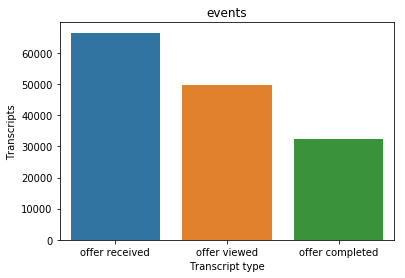

In [37]:
sns.countplot(df['event'])
plt.title('events')
plt.ylabel('Transcripts')
plt.xlabel('Transcript type')
plt.xticks(rotation = 0)
plt.show();

#### The above graph clearly shows us that more offers were received than those that were completed, 
#### Thus most people received and viewed the offers but didnot actually complete the transactions.

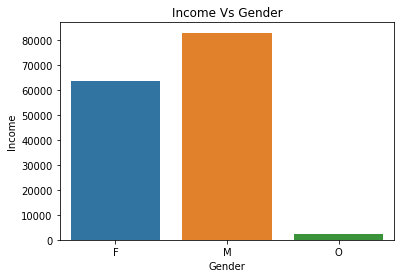

In [38]:
sns.countplot(x = df[df['gender'] != 'NA']['gender'])
plt.title('Income Vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [39]:
df.age.describe()

count    148805.000000
mean         54.779282
std          17.193533
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         101.000000
Name: age, dtype: float64

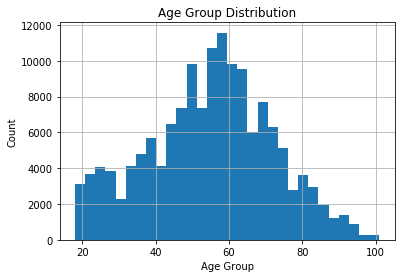

In [40]:
df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

### Observations
##### According to the chart above, we can clearly see that the majority of the customers are in the range of 50-65 years
##### The mean age is 55 years

Text(0.5,1,'Gender Distribution')

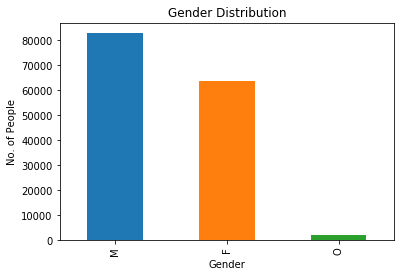

In [41]:
ax = df.gender.value_counts()
ax.plot(kind = 'bar')
plt.ylabel('No. of People')
plt.xlabel('Gender')
plt.title('Gender Distribution')

##### We have more male users of the app than the ladies

Text(0.5,1,'Offers Distribution')

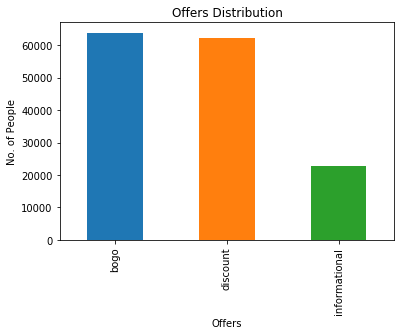

In [42]:
ax = df.offer_type.value_counts()
ax.plot(kind = 'bar')
plt.ylabel('No. of People')
plt.xlabel('Offers')
plt.title('Offers Distribution')

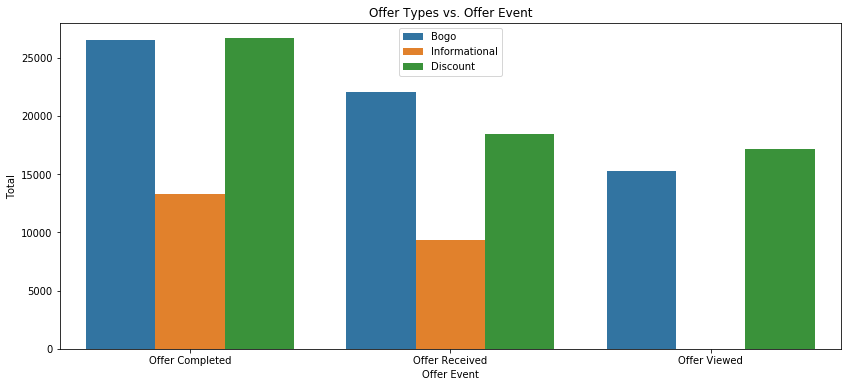

In [43]:
#Offer Types vs. Offer Events

plt.figure(figsize=(14,6))
g = sns.countplot(x= 'event', hue = 'offer_type', data = df)
Event = ['Offer Completed', 'Offer Received', 'Offer Viewed']
plt.title('Offer Types vs. Offer Event')
plt.ylabel('Total')
plt.xlabel('Offer Event')
plt.legend(['Bogo','Informational','Discount'])
g.set_xticklabels(Event)
plt.show();

Observations:
More Discount and BOGO offers were responded to than informational offers

In [44]:
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,...,duration,offer_type,reward,web,email,social,mobile,bogo,informational,discount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,75,2017-05-09,...,3.0,informational,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,75,2017-05-09,...,3.0,informational,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [45]:
df[['offer_type', 'offer received', 'offer viewed', 'offer completed']].groupby(['offer_type']).sum().reset_index()

,offer_type,offer received,offer viewed,offer completed
0,bogo,26537.0,22039.0,15258.0
1,discount,26664.0,18461.0,17186.0
2,informational,13300.0,9360.0,0.0


### Which demographic groups respond best to which offer type?

In [46]:
# Making age groups
df['age_groups'] = pd.cut(x=df['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109])

In [47]:
df['age_groups'].unique()

[(69, 79], (59, 69], (49, 59], (79, 89], (39, 49], (19, 29], (89, 99], (29, 39], (10, 19], (99, 109]]
Categories (10, interval[int64]): [(10, 19] < (19, 29] < (29, 39] < (39, 49] ... (69, 79] < (79, 89] < (89, 99] < (99, 109]]

In [48]:
df['age_by_decade'] = pd.cut(x=df['age'], bins=[10,19, 29, 39, 49, 59, 69, 79, 89, 99, 109], 
                             labels=['Late Teens', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '110s'])

In [49]:
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,...,reward,web,email,social,mobile,bogo,informational,discount,age_groups,age_by_decade
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,75,2017-05-09,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,75,2017-05-09,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s


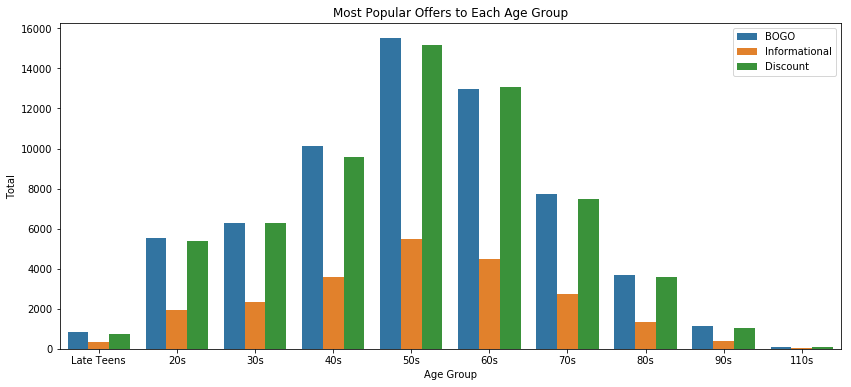

In [50]:
# Finding the most popular offers according to each age group
plt.figure(figsize=(14, 6))
g = sns.countplot(x='age_by_decade', hue="offer_type", data= df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(['BOGO', 'Informational','Discount'])
plt.show();

### Observations
#### We clearly observe that the 50's and 60's age groupgs are more responsive to the BOGO and Discount Offers and Informational offers generally generate less attention.
#### In general it can be concluded that all age groups best respond to BOGO and Discount Offers.

## Data Modeling

In [51]:
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,...,reward,web,email,social,mobile,bogo,informational,discount,age_groups,age_by_decade
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,75,2017-05-09,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,75,2017-05-09,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s


A machine learning model that predicts which offer type people are more likely to respond to. We split The 
split the dataframe into training and test data.


In [52]:
#to prepare the data for modeling, create dummies for the different offer types

# converting offer type to numerical form
offer_type = df['offer_type'].astype('category').cat.categories.tolist()
num_offer_type = {'offer_type' : {k: v for k,v in zip(offer_type,list(range(1,len(offer_type)+1)))}}
df.replace(num_offer_type, inplace=True)


In [53]:
# converting gender to numerical form
gender = df['gender'].astype('category').cat.categories.tolist()
num_gender = {'gender' : {k: v for k,v in zip(gender,list(range(1,len(gender)+1)))}}
df.replace(num_gender, inplace=True)

In [54]:
#to predict which model would best be get a reaction when it has been received, we only consider those people that have received
# offers

df = df[~(df['offer received'] == 0)]
df.head()

,event,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,...,reward,web,email,social,mobile,bogo,informational,discount,age_groups,age_by_decade
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,...,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,75,2017-05-09,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
10,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0,0,75,2017-05-09,...,10.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
12,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,75,2017-05-09,...,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,"(69, 79]",70s
18,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,68,2018-04-26,...,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,"(59, 69]",60s


In [55]:
df.describe()

,time,offer completed,offer received,offer viewed,transaction,age,gender,income,difficulty,duration,offer_type,reward,web,email,social,mobile,bogo,informational,discount
count,66501.000000,66501.0,66501.0,66501.0,66501.0,66501.000000,66501.000000,66501.000000,66501.00000,66501.000000,66501.000000,66501.000000,66501.000000,66501.0,66501.000000,66501.000000,66501.0,66501.0,66501.0
mean,332.610818,0.0,1.0,0.0,0.0,54.369258,1.600908,65371.618472,7.71417,6.507571,1.800950,4.198824,0.799612,1.0,0.598517,0.898859,0.0,0.0,0.0
std,196.528671,0.0,0.0,0.0,0.0,17.395430,0.517078,21623.288473,5.54754,2.204416,0.747951,3.398100,0.400294,0.0,0.490202,0.301518,0.0,0.0,0.0
min,0.000000,0.0,1.0,0.0,0.0,18.000000,1.000000,30000.000000,0.00000,3.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0
25%,168.000000,0.0,1.0,0.0,0.0,42.000000,1.000000,49000.000000,5.00000,5.000000,1.000000,2.000000,1.000000,1.0,0.000000,1.000000,0.0,0.0,0.0
50%,408.000000,0.0,1.0,0.0,0.0,55.000000,2.000000,64000.000000,10.00000,7.000000,2.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
75%,504.000000,0.0,1.0,0.0,0.0,66.000000,2.000000,80000.000000,10.00000,7.000000,2.000000,5.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0
max,576.000000,0.0,1.0,0.0,0.0,101.000000,3.000000,120000.000000,20.00000,10.000000,3.000000,10.000000,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0


In [56]:
# Split into training and testing data
X= df[['duration','age','gender','reward','email','mobile','social','web', 'difficulty','income']]
y = df['offer_type']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size=0.20, 
                                                        random_state=42)

In [58]:
clf1 = DecisionTreeClassifier()                
clf2 = RandomForestClassifier()
classifier_list = [clf1,clf2]

In [59]:
clf_dict = {}
for clf in classifier_list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test, y_pred, average='weighted')
    clf_dict[clf.__class__.__name__] = accuracy

In [60]:
print(clf_dict)

{'DecisionTreeClassifier': 1.0, 'RandomForestClassifier': 1.0}


In [61]:
parameters = {#'clf__estimator__n_estimators': [10]
             'n_estimators': [5,10],
            'min_samples_split': [2,3,4]}
             #'clf__estimator__min_samples_split': [2,3]}

cv = GridSearchCV(estimator = clf2, param_grid = parameters)

In [62]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
print('Training F1_score:', cv.score(X_train,y_train))
print('Test F1_score:', cv.score(X_test,y_test))

Training F1_score: 1.0
Test F1_score: 1.0


#### What to consider before particular offers are sent.

In [64]:
cv.best_estimator_.feature_importances_

array([  2.21935807e-01,   8.63638605e-05,   4.06277962e-06,
         3.58036053e-01,   0.00000000e+00,   0.00000000e+00,
         2.87512256e-02,   3.07028716e-02,   3.60430897e-01,
         5.27184124e-05])

In [65]:
feature_importances = pd.DataFrame(cv.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [66]:
feature_importances

,importance
difficulty,0.360431
reward,0.358036
duration,0.221936
web,0.030703
social,0.028751
age,0.000086
income,0.000053
gender,0.000004
email,0.000000
mobile,0.000000


### Conclusion 

1. The people in the age range of 50-65 are more likely to visit a Starbucks
2. Overall, Bogo is the most popular kind of Offer Type
3. Looking at different age groups, we can see that Bogo is popular than any other type of offers except for the ones in theirs 30s where it is as popular as the Discount offer and the ones who are in their 60s where Discount is more popular. But Informational is the least popular of all in all age groups
4. In most of the cases, the offers were received but not completed. Discount offer was the which was received by most and also completed followed by BOGO

And created a Machine Learning model using Random Forest Classifier  with the accuracy of 1. 
I may be getting an accuracy of 1 due to considering only the most important features and dropping all unnecessary features.

#### 5. Its also key to note that unlike what would be expected, income doesnot affect the choice on whether to act complete an offer or not, rather the duration, difficulty and reward are the key factors.

There may be overfitting which can be solved by considering more data.
As more rows were eliminated due to Nan values and duplicates the model had less data to work with.
The data available on the customer should also be indepth to define each individual customer. The features of the customer would have helped in producing better classification model results.
